In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

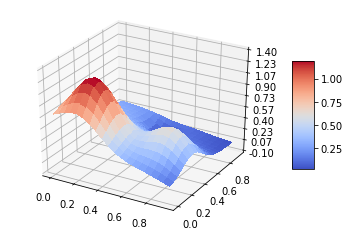

In [3]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [4]:
def CreateDesignMatrix_X(x, y, n = 5):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [5]:
n_x = 100   # number of points
m = 5        # degree of polynomial

# sort the random values, else your fit will go crazy
#x = np.sort((np.random.uniform(0, 1, n_x)))
#y = np.sort(np.random.uniform(0, 1, n_x))

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

#Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_true = np.ravel(z)
z_1 = np.ravel(z) + np.random.normal(size=n)*1 #np.random.random(n) * 1

# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1 is the function that gives the data, X is the design matrix

Then inverse the matrix and find β, and perform the linear regression (where ztilde is the model):

In [6]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

In [7]:
# For the true function (without the noise)

beta_t = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_true)
ztilde_t = X @ beta_t

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

ax1.scatter(x, y, z, 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )

ax1.scatter(x, y, z_1.reshape(x.shape), 
           alpha=1, 
           s=0.1, 
           color='black'
           )

ax1.plot_surface(x, y, ztilde.reshape(x.shape), 
                alpha=0.4, 
                cmap=cm.coolwarm,
                )

plt.title(f'OLS regression fit')
plt.show()

Find the confidence intervals of the parameters β by computing their variances: 
?????

In [9]:
np.var(beta)

591.4261627412685

Next we evaluate the Mean Squared error (MSE) and the R2 score function for the model (ztilde). We evaluate it with the real FrankeFunction, the one without the noise. 

In [10]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

print(MSE(z_true, ztilde))

0.005518037618482567


The MSE is ideally zero, since the smaller the value the better the fit. Here we observe an MSE of 0.09, which is pretty low, therefore indicating a good fit of the model.

In [11]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

print(R2(z_true, ztilde))

0.9330148177628268


The R2 score gives the coefficient of determination, which indicates how well the model predicts future samples. The best score would be 1.0. Given that the model has a score of 0.5 , this indicates that the model would explain 50% of the future samples correct, which is quite low (not sure if we can say this though).

# Part b) Resampling techniques, adding more complexity

First split the dataset in training data and test data

In [12]:
X_train, X_test, z_train, z_test, z_true_train, z_true_test = train_test_split(X, z_1, z_true, test_size=0.2)

# Get the new model from the training data
beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta2

# And the predictions for the test data
zpredict = X_test @ beta2

In [13]:
print("Training MSE:", MSE(z_train, ztilde1))
print("Test MSE:", MSE(z_test, zpredict))
print("True MSE:", MSE(z_true_test, zpredict))

print("Training R2:", R2(z_train, ztilde1))
print("Test R2:", R2(z_test, zpredict))
print("True R2:", R2(z_true_test, zpredict))

Training MSE: 1.0023313468920592
Test MSE: 1.0111904343189484
True MSE: 0.006055721963252487
Training R2: 0.0895819682148522
Test R2: 0.08702983678641918
True R2: 0.9273310877099603


The big difference between the R2 score for the test and true data are not weird, only the r2 score for the true data is interesting here. Because of the noise the R2 score for the test data is not very relevant. The training MSE can be below 1 but should be around one because your noise is * 1. The test MSE however should be 1 or slightly above, and it is kind of weird that it is smaller than 1 here, but it could be due to the small test size we are using. 

K-fold cross validation

In [14]:
# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [15]:
def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_test = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
    
    r2_test = np.array(r2_test)
    mse_test = np.array(mse_test)
    print("R2-Score: %0.3f (+/- %0.3f)" % (r2_test.mean(), r2_test.std() * 2))
    print("MSE-Score: %0.5f (+/- %0.5f)" % (mse_test.mean(), mse_test.std() * 2))
        
    return r2_test, mse_test

In [16]:
r, m = cross_validation(X, z_1, k)

R2-Score: 0.085 (+/- 0.023)
MSE-Score: 1.00858 (+/- 0.05461)


In [17]:
print(r)

[0.08500008 0.08937261 0.07591999 0.08554421 0.08220563 0.10681423
 0.10364998 0.08004803 0.0706554  0.07139498]


Perform the sk-learn cross-validation to estimate R2 and MSE

In [18]:
linreg = skl.LinearRegression()
linreg.fit(X_train, z_train)

ztilde2 = linreg.predict(X_test)

In [19]:
scores_test = cross_val_score(linreg, X_test, z_test, cv = kfold)
print(scores_test)

scores_true = cross_val_score(linreg, X_test, z_true_test, cv = kfold)
print(scores_true)

[ 0.04349753  0.06910027  0.09391011  0.10208438  0.07925549  0.02934361
  0.03233376 -0.00681875  0.13003412  0.10048201]
[0.97417545 0.97708098 0.97420918 0.97484672 0.96641528 0.97930881
 0.97643656 0.97306368 0.97280093 0.97666431]


In [20]:
print("R2-Score noisy data: %0.2f (+/- %0.2f)" % (scores_test.mean(), scores_test.std() * 2))
print("R2-Score real data: %0.2f (+/- %0.2f)" % (scores_true.mean(), scores_true.std() * 2))

R2-Score noisy data: 0.07 (+/- 0.08)
R2-Score real data: 0.97 (+/- 0.01)


In [21]:
scores_mse_test = cross_val_score(linreg, X_test, z_test, scoring='neg_mean_squared_error', cv=kfold)
scores_mse_true = cross_val_score(linreg, X_test, z_true_test, scoring='neg_mean_squared_error', cv=kfold)

In [22]:
estimated_mse_test = np.mean(-scores_mse_test)
estimated_mse_true = np.mean(-scores_mse_true)

print('MSE-score noisy data:', estimated_mse_test)
print('MSE-score real data:', estimated_mse_true)

MSE-score noisy data: 1.0245896542861368
MSE-score real data: 0.002081180993802071


The R2-score and MSE are better for the real data then for the test data, which shows that the model does not predict the noise but the data, which is positive

# Part C) Bias-variance tradeoff

In [22]:
maxdegree = 25

testerror = np.zeros(maxdegree)
trainerror = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

In [23]:
testerror = np.zeros(maxdegree)
trainingerror = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

trials = 10

for polydegree in range(1, maxdegree):
    polynomial[polydegree] = polydegree
    for degree in range(polydegree):
        DM = CreateDesignMatrix_X(x_1, y_1, n=degree)

    testerror[polydegree] = 0.0
    trainingerror[polydegree] = 0.0
    for samples in range(trials):
        DM_train, DM_test, z_1_train, z_1_test = train_test_split(DM, z_1, test_size=0.2, shuffle=False)

        model = LinearRegression(fit_intercept=True).fit(DM_train, z_1_train)
        zpred = model.predict(DM_train)
        ztilde = model.predict(DM_test)
        testerror[polydegree] += mean_squared_error(z_1_test, ztilde)
        trainingerror[polydegree] += mean_squared_error(z_1_train, zpred) 

    testerror[polydegree] /= trials
    trainingerror[polydegree] /= trials
    #print("Degree of polynomial: %3d"% polynomial[polydegree])
    #print("Mean squared error on training data: %.8f" % trainingerror[polydegree])
    #print("Mean squared error on test data: %.8f" % testerror[polydegree])

plt.plot(polynomial, np.log10(trainingerror), label='Training Error')
plt.plot(polynomial, np.log10(testerror), label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


# Part D) Ridge Regression on the Franke function with resampling

First remove the first column (the intercept) so that this one is not penalised by lambda (???) You don't need to remove the intercept column for this project. Normally, if you remove the intercept column you also have to take the mean blabla something

In [23]:
_lambda = 10**-2

In [24]:
betaridge = np.linalg.inv(X_train.T.dot(X_train)+(_lambda*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
zridge = X_train @ betaridge

ridge_predict = X_test @ betaridge

In [25]:
print("var(beta) OLS:", np.var(beta))
print("var(beta) ridge:", np.var(betaridge))

var(beta) OLS: 591.4261627412685
var(beta) ridge: 33.36697396669449


In [26]:
print("MSE OLS:", MSE(z_true_test, zpredict))
print("MSE ridge:", MSE(z_true_test, ridge_predict))

MSE OLS: 0.006055721963252487
MSE ridge: 0.007229205685090409


In [27]:
print("R2 OLS:", R2(z_true_test, zpredict))
print("R2 Ridge:", R2(z_true_test, ridge_predict))

R2 OLS: 0.9273310877099603
R2 Ridge: 0.913262340218029


The ridge regression for different lambdas, to find out which lambda is best

In [28]:
nlambdas = 500
lambdas = np.logspace(-7, 5, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

mse_scores_KFold = np.zeros((nlambdas, k))
r2_scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(X_train.T.dot(X_train)+(lmb*np.eye(len(X_train[0])))).dot(X_train.T).dot(z_train)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        Xtrain_r = X[train_inds]
        ztrain_r = z_1[train_inds]

        Xtest_r = X[test_inds]
        ztest_r = z_true[test_inds]
        
        zpred_r = Xtest_r @ betaridge1

        mse_scores_KFold[i,j] = np.sum((zpred_r - ztest_r)**2)/np.size(zpred_r)
        #r2_scores_KFold[i,j] = 1 - np.sum((ztest_r - zpred_r) ** 2) / np.sum((ztest_r - np.mean(zpred_r)) ** 2)

        j += 1
    i += 1

estimated_mse_KFold = np.mean(mse_scores_KFold, axis = 1)
#estimated_r2_KFold = np.mean(r2_scores_KFold, axis = 1)

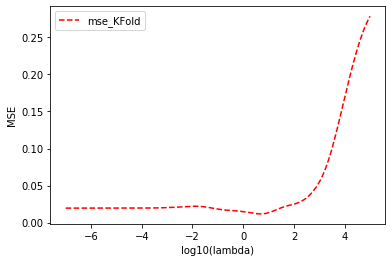

In [29]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

The same with sklearn and GridSearchCV. 
sklearn automatically splits the data (because of the CV) so put in the whole dataset here, and not the train data! it tests on the noisy data though, that's where the difference comes from. The negative MSE means that it is just the other side of the MSE so you can 'ignore' the minus sign

In [30]:
param_grid = {'alpha': lambdas}

ridge = Ridge()

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X, z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 0.9953962309984243}
-1.0335885953471482


In [31]:
nlambdas = 500
lambdas = np.logspace(-7, 5, nlambdas)

k = 10
kfold = KFold(n_splits = k, shuffle=True)

estimated_mse_sklearn = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    estimated_mse_folds = cross_val_score(ridge, X, z_1, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1

print(np.mean(estimated_mse_sklearn))

1.022644322080145


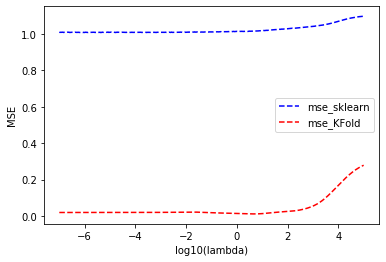

In [32]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, 'b--', label = 'mse_sklearn')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'mse_KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Part E) Lasso Regression on the Franke function with resampling


Start by finding the optimal value for lambda for lasso, using GridSearchCV

In [ ]:
nlambdas = 500
lambdas_lasso = np.logspace(-4, 10, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = Lasso(precompute = True, tol = 0.001)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=10)
lasso_regressor.fit(X, z_1)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

The optimal value for lambda is around 3.2^-4. If we use this value for lambda we can compare the MSE and R2 scores for all three models

In [55]:
l_lambda = 0.00032

clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 0.01).fit(X_train, z_train)
pred_lasso = clf_lasso.predict(X_test)

In [56]:
print("MSE OLS:", MSE(z_true_test, zpredict))
print("MSE ridge:", MSE(z_true_test, ridge_predict))
print("MSE lasso:", MSE(z_true_test, pred_lasso))

MSE OLS: 0.006055721963252487
MSE ridge: 0.007229205685090409
MSE lasso: 0.010743122288720442


In [57]:
print("R2 OLS:", R2(z_true_test, zpredict))
print("R2 Ridge:", R2(z_true_test, ridge_predict))
print("R2 lasso:", R2(z_true_test, pred_lasso))

R2 OLS: 0.9273310877099603
R2 Ridge: 0.913262340218029
R2 lasso: 0.8711220469650718


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.164972952543394, tolerance: 9.817500743249553
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239.3409790403639, tolerance: 9.849174086117117
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154.14047120684972, tolerance: 9.863877561863152
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 114.65186292895305, tolerance: 10.002499993677453
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180.06002058203012, tolerance: 10.000373652609097
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69.9682029376172, tolerance: 9.860491248709447
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conve

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 71.16964310119056, tolerance: 9.983779316434733
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61.4602778485405, tolerance: 9.996223942701176
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.388198386279328, tolerance: 10.002499993677453
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.05450913173445, tolerance: 9.849174086117117
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.898839246221542, tolerance: 9.857561817837151
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26.08151728071607, tolerance: 9.996223942701176
  tol, rng, random, positive)
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

{'alpha': 0.00031989689154345377}
-1.0219724578267315


/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.080858011715463, tolerance: 11.023249673922441
  tol, rng, random, positive)
